In [1]:
!pip install polars
!pip install hvplot
!pip install yfinance
!pip install seaborn
!pip install pyarrow
!pip install scipy

import csv
import polars as pl
import yfinance as yf
import pyarrow
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

In [19]:
class Data_Engineering():
    def __init__(self, year):
        self.year = year
        self.value_asset_data = dict()
        self.price_data = dict()
        self.amount_data = dict()

    @staticmethod
    def to_polars(dictionary):
        """
        To convert dictionaries into polars dataframe
        """
        return pl.DataFrame(dictionary) 
    
    @staticmethod
    def _concatenate_dicts(dict1, dict2):
        """
        Hidden function which concatenates two dictionaries based on common keys, values for each key are already sorted

        Args:
        - dict1 (dict): First dictionary.
        - dict2 (dict): Second dictionary.

        Returns:
        - concatenated_dict (dict): A new dictionary with concatenated lists for matching keys.
        """

        concatenated_dict = {}
        keys = set(dict1.keys()) & set(dict2.keys()) # find the intersection of keys
        for key in keys: # for each commons keys, concatenate their values
            concatenated_dict[key] = dict1[key] + dict2[key]
        return concatenated_dict

    def value_asset_data_retriever(self, asset_line_end, asset_line_start=3, to_polars=False):
        """
        Retrieve data from a file stored in the source_files folder, whose name is in the format "YYYY.csv". Lines contains monthly value for each asset in rows, calculated at the end of each month.
        
        Args:
            asset_line_end (int): what's the last line corresponding to an asset
            asset_line_start (int, default = 3): what's the first line corresponding to an asset
            to_polars (bool, default = False): convert to polar

        """
        with open('source_files/' + str(self.year) + '.csv', mode='r') as f:
            reader = csv.reader(f)
            # Skip the first 3 lines
            for _ in range(asset_line_start):
                next(reader)

            # create a dictionary whose keys are tickers and values are the list of values in dollars for each asset, for each month
            for i, values in enumerate(reader):
                if i == asset_line_end - asset_line_start:
                    break
                self.value_asset_data[values[0]] = list(map(lambda x: int(x.replace(',', '')), values[3:15]))

        if to_polars:
            self.value_asset_data = self.to_polars(self.value_asset_data)

    def price_data_retriever(self, sampling = 'ME', to_polars=False):
        """
        Retrieve closing price data from yahoo finance for each ticker, in the given year
        
        Args:
            sampling (string, default = 'ME'): what's the frequency of data? 'ME' for monthly data
            to_polars (bool, default = False): convert to polar

        """
        tickers = list(self.value_asset_data.keys())
        for ticker in tickers:
            if ticker == "INTEL":   # to be deleted
                continue            # to be deleted
            self.price_data[ticker] = yf.Ticker(ticker).history(start = str(self.year) + '-01-01', 
                                                                end=str(self.year + 1) + '-01-01')['Close']
            if sampling == 'ME':
                self.price_data[ticker] = self.price_data[ticker].resample('ME').last().tolist()
                
        if to_polars:
            self.price_data = self.to_polars(self.price_data)

    def amount_data_calculator(self, to_polars=False):
        """
        Calculate the amount of asset each month, per each ticker
        """

        for key in self.value_asset_data:
            if key == "INTEL":      # to be deleted
                continue            # to be deleted
            self.amount_data[key] = [value / price for value, price in zip(self.value_asset_data[key], self.price_data[key])]

        if to_polars:
            self.amount_data = self.to_polars(self.amount_data)

    def get_difference(self, mode, diff=1, pct_change=False):
        """
        Calculate absolute or percentuale change in price or amount of asset per each moment
        
        Args:
            mode (string): "price" or "amount", according to the data to calculate the difference of
            diff (int, default = 1): lag
            pct_change (bool, default = False): calculate the percentuale change
        
        Returns:
            pl.Dataframe (polar dataframe)
        """
        if mode == "price":
            data = self.price_data if isinstance(self.price_data, pl.DataFrame) else self.to_polars(self.price_data)
            if pct_change:
                self.price_difference_pct = data.select(pl.all().pct_change(diff))
                return self.price_difference_pct
            else:
                self.price_difference = data.select(pl.all().diff(diff))
                return self.price_difference

        elif mode == "amount":
            data = self.amount_data if isinstance(self.amount_data, pl.DataFrame) else self.to_polars(self.amount_data)
            self.difference_amount = data.select(pl.all().diff(diff))
            return self.difference_amount

    def concatenate_data(self, older):
        """
        Concatenate data from another DataEngineering instance into this one.

        Args:
        - older (InstanceClass): Another instance of DataEngineering to concatenate with.

        Returns:
        - new_instance (InstanceClass): A new instance with concatenated data.
        """
        concatenated_value_asset_data = self._concatenate_dicts(older.value_asset_data, self.value_asset_data)
        concatenated_price_data = self._concatenate_dicts(older.price_data, self.price_data)
        concatenated_amount_data = self._concatenate_dicts(older.amount_data, self.amount_data)
        
        # Create a new instance with default year and updated data
        new_instance = Data_Engineering(year = self.year)
        new_instance.value_asset_data = concatenated_value_asset_data
        new_instance.price_data = concatenated_price_data
        new_instance.amount_data = concatenated_amount_data
        return new_instance

data_2023 = Data_Engineering(2023)
data_2023.value_asset_data_retriever(13)
data_2023.price_data_retriever()
data_2023.amount_data_calculator()

data_2022 = Data_Engineering(2022)
data_2022.value_asset_data_retriever(16)
data_2022.price_data_retriever()
data_2022.amount_data_calculator()

# Concatenate data

data_2022_2023 = data_2023.concatenate_data(data_2022)

# Exploratory Data Analysis

In [12]:
value_dataframe = pd.DataFrame(data_2022_2023.value_asset_data)
plt.style.use('ggplot')

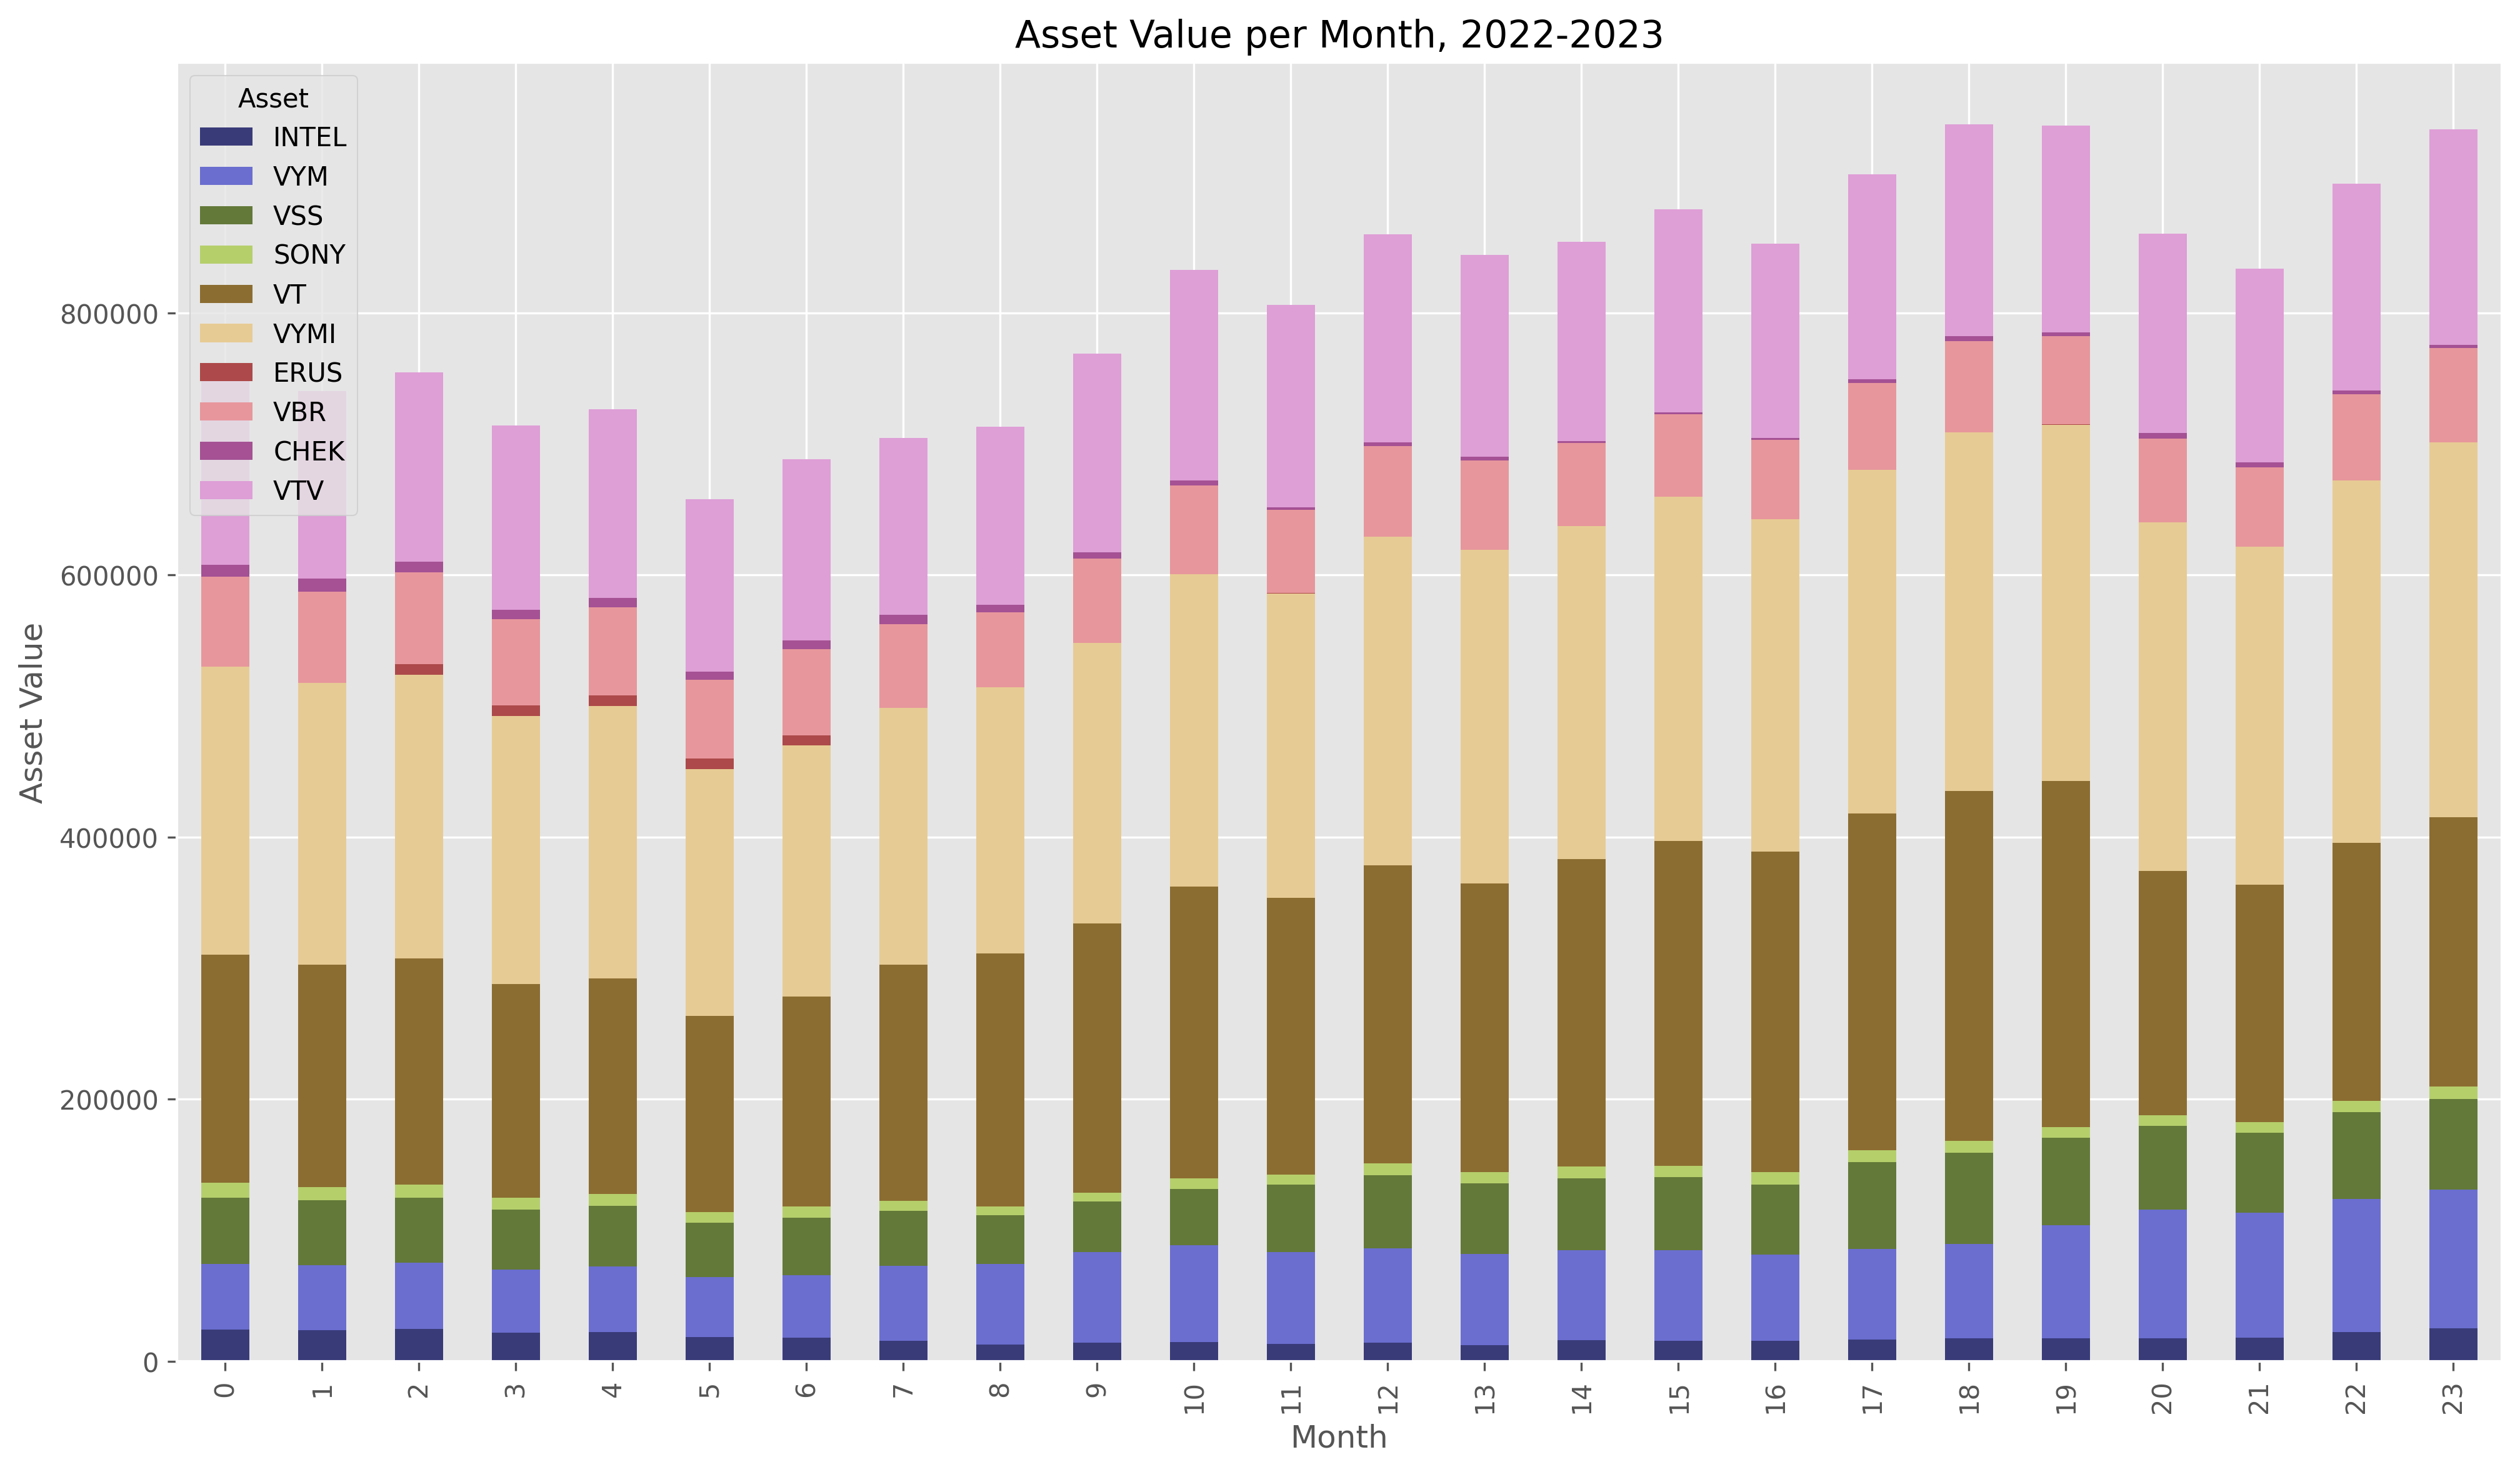

In [13]:

value_dataframe.plot(kind = 'bar', stacked = True, colormap = 'tab20b', figsize=(16,9))
# Setting the DPI
plt.gcf().set_dpi(300)
plt.xlabel('Month')
plt.ylabel('Asset Value')
plt.title('Asset Value per Month, 2022-2023')
plt.legend(title='Asset', loc='upper left')
plt.show()

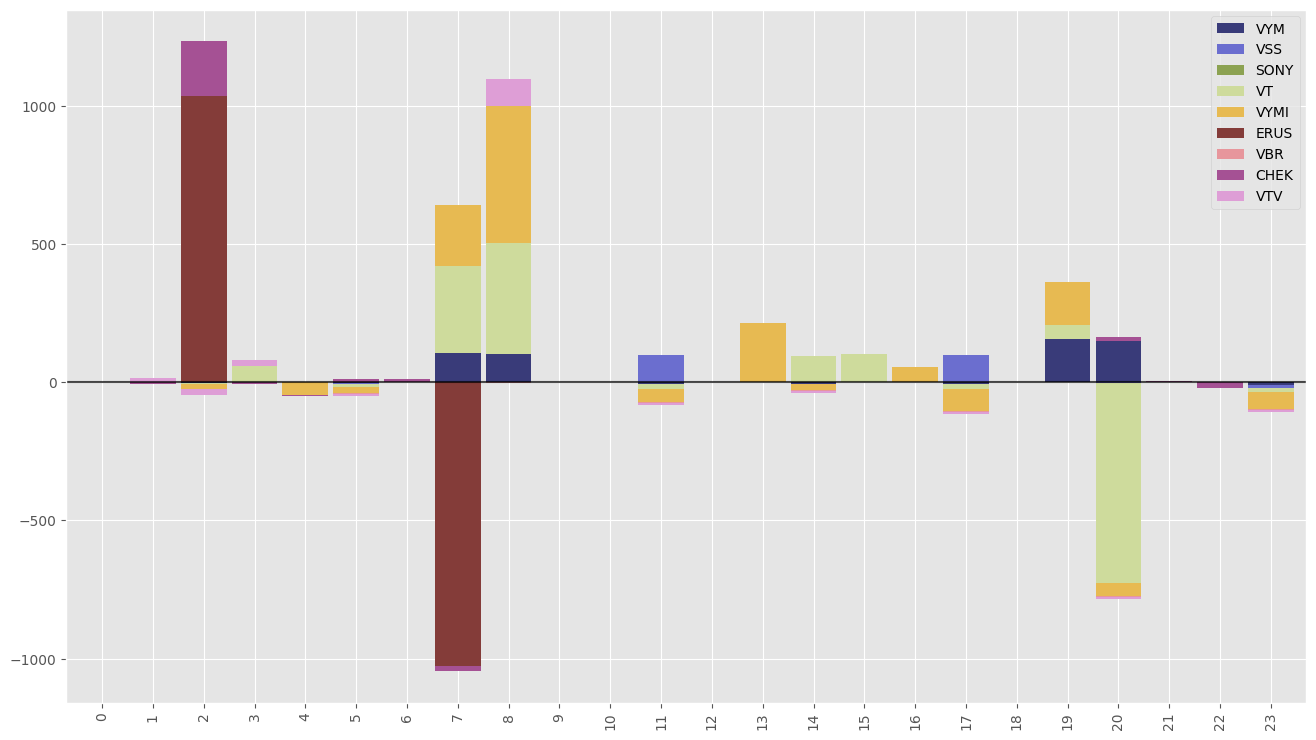

In [49]:
test.plot(kind = 'bar', figsize = (16,9), stacked = True, width = 0.9, colormap = 'tab20b')
plt.axhline(y = 0, color = 'black', alpha = 0.7)
plt.show()

In [96]:
amount_difference, price_difference = data_2022_2023.get_difference('amount').to_pandas(), data_2022_2023.get_difference('price', pct_change = True).to_pandas()*100

In [138]:
prova = pd.concat([amount_difference['VYMI'], price_difference['VYMI']], axis = 1).set_axis(["A", "P"], axis = 1).dropna()
prova

,A,P
1,0.000411,-2.009037
2,-16.635178,0.926515
3,-0.000040,-5.575273
4,-45.219374,3.101003
5,-21.908049,-8.944385
6,-0.000234,1.615104
7,219.963306,-3.563666
8,496.874223,-8.585204
9,0.000294,5.399685
10,-0.000630,11.394729


In [139]:
import scipy.stats as stat
res = stat.pearsonr(x = prova['P'], y = prova['A'])
res

PearsonRResult(statistic=np.float64(-0.5030605682253748), pvalue=np.float64(0.0144126615177122))